In [1]:
import sys
import os
current_path = os.getcwd()  # 获取当前工作目录
print("当前路径:", current_path)
current_path = current_path.replace('/samples', '')
print(sys.path)  # 显示所有模块搜索路径
sys.path.append(current_path)  # 添加自定义路径
print(sys.path)  # 显示所有模块搜索路径

In [2]:
import pandas as pd
import numpy as np 
import QuantLib as ql 
import math
from datetime import datetime

from src.QlCalendar import QlCalendar
from src.QlStocks import QlStocks
from src.QlEuropeanOptions import QlEuropeanOptions
from src.utils import plot_multi_y_axis, unix_time_to_ql_dates

In [3]:
df = pd.read_feather(r'../data/tsla_2019_2022.feather')
df.head(10)

,QUOTE_UNIXTIME,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,...,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
1536366,1546462800,2019-01-02,310.12,2019-01-04,1546635600,0.89752,0.00000,0.03123,-0.10511,0.00100,...,0.01,-0.00193,0.00011,0.00155,-0.03743,-0.00053,2.38828,0.0,135.1,0.436
1536367,1546462800,2019-01-02,310.12,2019-01-04,1546635600,0.89822,0.00006,0.03228,-0.53068,0.00249,...,0.02,-0.00474,0.00015,0.00365,-0.08675,-0.00010,2.49584,4.0,130.1,0.420
1536368,1546462800,2019-01-02,310.12,2019-01-04,1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.02,-0.00041,0.00000,0.00103,-0.00991,0.00000,1.92119,0.0,125.1,0.403
1536369,1546462800,2019-01-02,310.12,2019-01-04,1546635600,0.90392,0.00012,0.03202,-0.52977,0.00221,...,0.02,-0.00144,0.00010,0.00145,-0.02916,0.00000,2.01225,1.0,120.1,0.387
1536370,1546462800,2019-01-02,310.12,2019-01-04,1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.01,-0.00095,0.00009,0.00081,-0.01419,0.00000,1.79481,2.0,115.1,0.371
1536371,1546462800,2019-01-02,310.12,2019-01-04,1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.01,0.00000,0.00007,0.00084,-0.00507,-0.00012,1.55763,34.0,110.1,0.355
1536372,1546462800,2019-01-02,310.12,2019-01-04,1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.01,-0.00097,0.00007,0.00132,-0.01489,0.00000,1.61323,78.0,105.1,0.339
1536373,1546462800,2019-01-02,310.12,2019-01-04,1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.02,-0.00158,0.00014,0.00087,-0.01468,-0.00019,1.52702,11.0,100.1,0.323
1536374,1546462800,2019-01-02,310.12,2019-01-04,1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.02,-0.00151,0.00009,0.00099,-0.01462,-0.00005,1.44319,69.0,95.1,0.307
1536375,1546462800,2019-01-02,310.12,2019-01-04,1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.05,-0.00109,0.00010,0.00109,-0.01419,-0.00052,1.35812,116.0,90.1,0.291


### 将日期结果转为ql.Date

In [4]:
dates_info = pd.DataFrame(
    np.vstack([
        df[['QUOTE_UNIXTIME', 'QUOTE_DATE']].values,
        df[['EXPIRE_UNIX', 'EXPIRE_DATE']].values
    ]),
    columns=['UNIX', 'DATE']  # 自定义新列名
)
dates_info.drop_duplicates(subset=['UNIX'], inplace=True)
dates_info['ql_date'] = unix_time_to_ql_dates(dates_info['UNIX'].values)

In [5]:
dates_info_dict = dates_info.set_index('UNIX')['ql_date'].to_dict()
df['QUOTE_DATE'] = df['QUOTE_UNIXTIME'].map(dates_info_dict)
df['EXPIRE_DATE'] = df['EXPIRE_UNIX'].map(dates_info_dict)

In [6]:
df

,QUOTE_UNIXTIME,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,...,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
1536366,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,0.89752,0.00000,0.03123,-0.10511,0.00100,...,0.01,-0.00193,0.00011,0.00155,-0.03743,-0.00053,2.38828,0.0,135.1,0.436
1536367,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,0.89822,0.00006,0.03228,-0.53068,0.00249,...,0.02,-0.00474,0.00015,0.00365,-0.08675,-0.00010,2.49584,4.0,130.1,0.420
1536368,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.02,-0.00041,0.00000,0.00103,-0.00991,0.00000,1.92119,0.0,125.1,0.403
1536369,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,0.90392,0.00012,0.03202,-0.52977,0.00221,...,0.02,-0.00144,0.00010,0.00145,-0.02916,0.00000,2.01225,1.0,120.1,0.387
1536370,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.01,-0.00095,0.00009,0.00081,-0.01419,0.00000,1.79481,2.0,115.1,0.371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138985,1672434000,"December 30th, 2022",123.19,"February 17th, 2023",1676667600,0.00090,0.00005,0.00137,-0.00127,0.00056,...,0.00,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,456.8,3.708
1138986,1672434000,"December 30th, 2022",123.19,"February 17th, 2023",1676667600,0.00086,0.00002,0.00119,-0.00191,0.00044,...,0.00,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,461.8,3.749
1138987,1672434000,"December 30th, 2022",123.19,"February 17th, 2023",1676667600,0.00062,0.00008,0.00134,-0.00165,-0.00007,...,0.00,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,466.8,3.789
1138988,1672434000,"December 30th, 2022",123.19,"February 17th, 2023",1676667600,0.00071,0.00001,0.00160,-0.00140,-0.00022,...,0.00,-1.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN,471.8,3.830


## 获得起始日期及当日股价

In [7]:
today_date = dates_info.iloc[0]['ql_date']
ql.Settings.instance().evaluationDate = today_date
today_price = df['UNDERLYING_LAST'].values[0]

today_date, today_price

(Date(2,1,2019), 310.12)

In [8]:
risk_free_rate = 0.3

### 构建日历和股票市场

In [9]:
# 构建日历和股票市场
ql_calendar = QlCalendar(init_date=today_date, init_risk_free_rate=risk_free_rate)
ql_stocks = QlStocks(ql_calendar)

### 创建基于bs模型的TSLA股票

In [10]:
# 创建基于bs模型的TSLA股票
ql_stocks.add_black_scholes(codes="TSLA", stock_prices=today_price)
tsla = ql_stocks.stock('TSLA')

### 构建tesla的期权集合

In [11]:
# 构建tesla的期权集合
tsla_options = QlEuropeanOptions(tsla)

## 获得起始日期的 options

In [12]:
today_df = df[df['QUOTE_DATE'] == today_date]
today_df

,QUOTE_UNIXTIME,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,...,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
1536366,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,0.89752,0.00000,0.03123,-0.10511,0.00100,...,0.01,-0.00193,0.00011,0.00155,-0.03743,-0.00053,2.38828,0.0,135.1,0.436
1536367,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,0.89822,0.00006,0.03228,-0.53068,0.00249,...,0.02,-0.00474,0.00015,0.00365,-0.08675,-0.00010,2.49584,4.0,130.1,0.420
1536368,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.02,-0.00041,0.00000,0.00103,-0.00991,0.00000,1.92119,0.0,125.1,0.403
1536369,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,0.90392,0.00012,0.03202,-0.52977,0.00221,...,0.02,-0.00144,0.00010,0.00145,-0.02916,0.00000,2.01225,1.0,120.1,0.387
1536370,1546462800,"January 2nd, 2019",310.12,"January 4th, 2019",1546635600,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.01,-0.00095,0.00009,0.00081,-0.01419,0.00000,1.79481,2.0,115.1,0.371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537047,1546462800,"January 2nd, 2019",310.12,"February 15th, 2019",1550264400,0.00289,0.00007,0.00929,-0.00807,0.00094,...,305.40,-1.00000,0.00000,2.35306,0.00000,0.00000,0.00070,9.0,339.9,1.096
1537048,1546462800,"January 2nd, 2019",310.12,"February 15th, 2019",1550264400,0.00285,0.00005,0.00872,-0.00728,0.00108,...,0.00,-1.00000,0.00000,2.35214,0.00000,0.00000,0.00058,NaN,349.9,1.128
1537049,1546462800,"January 2nd, 2019",310.12,"February 15th, 2019",1550264400,0.00125,0.00002,0.00556,-0.00471,0.00055,...,370.50,-1.00000,0.00000,2.35118,0.00000,0.00000,0.00017,2.0,359.9,1.160
1537050,1546462800,"January 2nd, 2019",310.12,"February 15th, 2019",1550264400,0.00166,0.00010,0.00437,-0.00348,0.00051,...,0.00,-0.99861,0.00003,0.00179,-0.00709,-0.83283,0.66746,NaN,369.9,1.193


In [13]:
# 在模型中建立这些期权
tsla_options.add_options(
    option_types = 'call',
    strike_prices = today_df['STRIKE'].values,
    maturity_dates = today_df['EXPIRE_DATE'].values,
)

codes                types  strike  maturity           
TSLA190104C00175000  call   175.0   January 4th, 2019      <QuantLib.QuantLib.EuropeanOption; proxy of <S...
TSLA190104C00180000  call   180.0   January 4th, 2019      <QuantLib.QuantLib.EuropeanOption; proxy of <S...
TSLA190104C00185000  call   185.0   January 4th, 2019      <QuantLib.QuantLib.EuropeanOption; proxy of <S...
TSLA190104C00190000  call   190.0   January 4th, 2019      <QuantLib.QuantLib.EuropeanOption; proxy of <S...
TSLA190104C00195000  call   195.0   January 4th, 2019      <QuantLib.QuantLib.EuropeanOption; proxy of <S...
                                                                                 ...                        
TSLA190215C00650000  call   650.0   February 15th, 2019    <QuantLib.QuantLib.EuropeanOption; proxy of <S...
TSLA190215C00660000  call   660.0   February 15th, 2019    <QuantLib.QuantLib.EuropeanOption; proxy of <S...
TSLA190215C00670000  call   670.0   February 15th, 2019    <QuantLib.Qua

### 使用解析解引擎

In [25]:
today_df[['EXPIRE_DATE', 'STRIKE', 'C_IV']].values

array([[Date(4,1,2019), 175.0, 4.50109],
       [Date(4,1,2019), 180.0, 4.3513],
       [Date(4,1,2019), 185.0, nan],
       ...,
       [Date(15,2,2019), 670.0, 0.71994],
       [Date(15,2,2019), 680.0, 0.71246],
       [Date(15,2,2019), 690.0, 0.72507]], dtype=object)

In [14]:
# 解析解 引擎
tsla_options.analytic_engines()

### compare IV

In [50]:
compare_IV_df = pd.DataFrame(
    today_df[['EXPIRE_DATE', 'STRIKE', 'C_IV']].values,
    columns=['EXPIRE_DATE', 'STRIKE', 'C_IV'],
    index = tsla_options.options_df.index
)
compare_IV_df['ql_C_IV'] = tsla_options.impliedVolatility(today_df['C_ASK'].values)

### 对比 February 8th, 2019 到期的期权，实际和计算的call IV

In [51]:
compare_IV_df1 = compare_IV_df[compare_IV_df['EXPIRE_DATE'] == ql.Date(8,2,2019)]
compare_IV_df1[(compare_IV_df1['STRIKE'].isin([270, 280, 290, 300, 310, 320]))]

,,,,EXPIRE_DATE,STRIKE,C_IV,ql_C_IV
codes,types,strike,maturity,,,,
TSLA190208C00270000,call,270.0,"February 8th, 2019","February 8th, 2019",270.0,0.77245,0.605410
TSLA190208C00280000,call,280.0,"February 8th, 2019","February 8th, 2019",280.0,0.75355,0.615903
TSLA190208C00290000,call,290.0,"February 8th, 2019","February 8th, 2019",290.0,0.73257,0.614519
TSLA190208C00300000,call,300.0,"February 8th, 2019","February 8th, 2019",300.0,0.71438,0.612063
TSLA190208C00310000,call,310.0,"February 8th, 2019","February 8th, 2019",310.0,0.69661,0.604079
TSLA190208C00320000,call,320.0,"February 8th, 2019","February 8th, 2019",320.0,0.67279,0.588443


<Axes: xlabel='strike'>

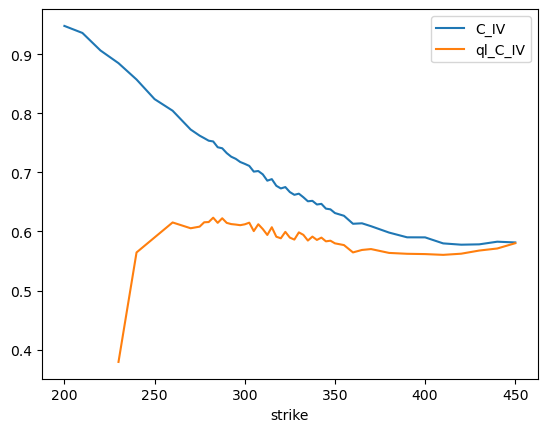

In [53]:
compare_IV_df1.reset_index(inplace=True)
compare_IV_df1.set_index('strike', inplace=True)
compare_IV_df1[['C_IV', 'ql_C_IV']].plot()

In [85]:
# strike = 270.0
ql_call_1 = tsla_options.options_df.xs('TSLA190208C00270000', level='codes').iloc[0]
ql_call_1

payoff      <QuantLib.QuantLib.PlainVanillaPayoff; proxy o...
exercise    <QuantLib.QuantLib.EuropeanExercise; proxy of ...
options     <QuantLib.QuantLib.EuropeanOption; proxy of <S...
Name: (call, 270.0, February 8th, 2019), dtype: object

In [89]:
call_1 = today_df[(today_df['STRIKE'] == 270) & (today_df['EXPIRE_DATE'] == ql.Date(8,2,2019))]
call_1[['EXPIRE_DATE', 'C_IV', 'C_BID', 'C_ASK', 'STRIKE', 'C_DELTA', 'P_IV']]

,EXPIRE_DATE,C_IV,C_BID,C_ASK,STRIKE,C_DELTA,P_IV
1536884,"February 8th, 2019",0.77245,52.1,53.95,270.0,0.75289,0.77359


In [81]:
ql_call_1['options'].impliedVolatility(52.1, tsla.process)

0.5255895937382236

# calculate NPV

In [44]:
tsla.set_volatility(0.67)

In [45]:
compare_IV_df = pd.DataFrame(
    today_df[['EXPIRE_DATE', 'STRIKE', 'C_BID']].values,
    columns=['EXPIRE_DATE', 'STRIKE', 'C_BID'],
    index = tsla_options.options_df.index
)
compare_IV_df['ql_C_BID'] = tsla_options.impliedVolatility(today_df['C_IV'].values)


array([1.35407435e+02, 1.30415647e+02, 1.25423860e+02, 1.20432072e+02,
       1.15440285e+02, 1.10448497e+02, 1.05456709e+02, 1.00464922e+02,
       9.54731343e+01, 9.04813468e+01, 8.54895592e+01, 8.04977716e+01,
       7.55059841e+01, 7.05141967e+01, 6.55224111e+01, 6.05306386e+01,
       5.55389430e+01, 5.05476252e+01, 4.55578568e+01, 4.05734505e+01,
       3.56048353e+01, 3.31331942e+01, 3.06761154e+01, 2.82403144e+01,
       2.58345222e+01, 2.34696170e+01, 2.11585780e+01, 1.89162153e+01,
       1.67586544e+01, 1.47025922e+01, 1.27643719e+01, 1.09589676e+01,
       9.29898239e+00, 7.79377865e+00, 6.44883924e+00, 5.26543298e+00,
       4.24061502e+00, 3.36754941e+00, 2.63610125e+00, 2.03361749e+00,
       1.54580181e+00, 1.15758984e+00, 8.53945224e-01, 6.20519156e-01,
       4.44141584e-01, 3.13136754e-01, 2.17475772e-01, 1.48792458e-01,
       1.00295833e-01, 6.66137780e-02, 4.35992579e-02, 2.81247728e-02,
       1.78838219e-02, 1.12115113e-02, 6.93067479e-03, 4.22544723e-03,
      